In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import faiss                   # make faiss available
import umap
import seaborn as sns
%matplotlib inline
from byol_pytorch import BYOL

import os
import sys
import matplotlib.pyplot as plt
from sklearn import svm
sys.path.append('..')

import torchvision.models as models
from torchvision import transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

from pl_bolts.models.self_supervised import SimCLR
import lightgbm as lgb
import kornia
from kornia.augmentation.container import AugmentationSequential

import torchvision.transforms.functional as tvF
from src.beam import UniversalDataset, Experiment, Algorithm, beam_arguments, PackedFolds, batch_augmentation
from src.beam import tqdm
from examples.ssl_with_beam import STL10Dataset, BeamSSL, BeamBarlowTwins, UniversalSSL, BarlowTwins, SimCLR, SimSiam, BYOL

2022-08-14 13:29:57.395784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
path_to_data = '/home/shared/data/dataset/stl10/stl10_binary'
root_dir = '/home/shared/data/results'

# hparams = beam_arguments(
#     f"--project-name=similarity --root-dir={root_dir} --algorithm=STL10 --identifier=dev  --device=0",
#     "--epoch-length-train=50 --epoch-length-eval=20 --no-scale-epoch-by-batch-size --batch-size=128 --override",
#     path_to_data=path_to_data)

In [3]:
# def show_image(i, aug=False):
    
#     dataset_labeled.normalize = True
#     key = 'x_aug' if aug else 'x'
#     im = np.array(dataset_labeled[i][1][key].permute(1, 2, 0))
#     plt.imshow(im)
#     plt.show()
#     dataset_labeled.normalize = True
    

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, fs=100, rescale=False):
    
    if rescale:
        imgs = torch.clip(((imgs + 1) / 2.0), 0, 1)
        
    imgs = imgs.detach().to('cpu')
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(fs, fs))
    for i, img in enumerate(imgs):
        img = tvF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [81]:
hparams = beam_arguments(BeamSSL.get_parser(),
        f"--project-name=beam_ssl --root-dir={root_dir}  --algorithm=SimCLR --device=0 --amp --model=convnext_base --pretrained --device=0 --layer=avgpool "
        f"--batch-size=256 --n-epochs=200", path_to_data=path_to_data)

experiment = Experiment(hparams, print_hyperparameters=False)

2022-08-14 14:02:27 | INFO | Creating new experiment
2022-08-14 14:02:27 | INFO | Experiment directory is: /home/shared/data/results/beam_ssl/SimCLR/debug/0010_20220814_140227


In [82]:
dataset_unlabeled = STL10Dataset(experiment.hparams, subset='unlabeled')
dataset_labeled = STL10Dataset(experiment.hparams, subset='labeled')

In [83]:
alg = experiment.algorithm_generator(SimCLR, dataset_unlabeled)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
features_train = alg.evaluate(dataset_labeled)

evaluate:   4%|3         | 2/51 [00:00<?, ?it/s]

In [85]:
z = features_train.values['h'].detach().cpu().numpy()
y = features_train.values['y'].detach().cpu().numpy()

In [86]:
index_train = np.array(dataset_labeled.indices['train'])
index_test = np.array(dataset_labeled.indices['test'])

## LightBGM

In [87]:
train_data = lgb.Dataset(z[index_train], label=y[index_train]-1)

In [88]:
validation_data = lgb.Dataset(z[index_test], label=y[index_test]-1)

In [89]:
%%time

num_round = 200
param = {'objective': 'multiclass', 
         'num_leaves': 31, 
         'max_depth': 4,
         'gpu_device_id': 1,
         'verbosity':-1,
         'metric': ['multi_error', 'multiclass'],
         'num_class': 10}
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

[1]	valid_0's multi_error: 0.187125	valid_0's multi_logloss: 1.73071
[2]	valid_0's multi_error: 0.14325	valid_0's multi_logloss: 1.44047
[3]	valid_0's multi_error: 0.121	valid_0's multi_logloss: 1.23345
[4]	valid_0's multi_error: 0.11	valid_0's multi_logloss: 1.07724
[5]	valid_0's multi_error: 0.1005	valid_0's multi_logloss: 0.952753
[6]	valid_0's multi_error: 0.092125	valid_0's multi_logloss: 0.852145
[7]	valid_0's multi_error: 0.088375	valid_0's multi_logloss: 0.764985
[8]	valid_0's multi_error: 0.084625	valid_0's multi_logloss: 0.691965
[9]	valid_0's multi_error: 0.08125	valid_0's multi_logloss: 0.629113
[10]	valid_0's multi_error: 0.077375	valid_0's multi_logloss: 0.574887
[11]	valid_0's multi_error: 0.0745	valid_0's multi_logloss: 0.528413
[12]	valid_0's multi_error: 0.073	valid_0's multi_logloss: 0.488036
[13]	valid_0's multi_error: 0.069875	valid_0's multi_logloss: 0.453366
[14]	valid_0's multi_error: 0.068125	valid_0's multi_logloss: 0.422308
[15]	valid_0's multi_error: 0.06637

## Faiss

In [90]:
class Similarity(object):
    
    def __init__(self, d, metric='l2', reducer='umap'):
        
        res = faiss.StandardGpuResources()
        index_flat = faiss.IndexFlatL2(d)
        self.index = faiss.index_cpu_to_gpu(res, 0, index_flat)
        
        if reducer == 'umap':
            self.reducer = umap.UMAP()
        elif reducer == 'tsne':
            self.reducer = TSNE()
        else:
            raise NotImplementedError
        
    def add(self, z):
        self.index.add(z)
        
    def most_similar(self, zi, n=1):
        D, I = self.index.search(zi, n)
        return D, I
    
    def __len__(self):
        return self.index.ntotal
    
    def reduce(self, z):
        return self.reducer.fit_transform(z)

In [91]:
sim = Similarity(z.shape[1])

In [92]:
sim.add(z)

In [93]:
D, I = sim.most_similar(z[[9002]], n=1000)

In [94]:
embedding = sim.reduce(z[I[0]])

In [121]:
def visualize(embedding, marked=None, label=None, mark_first=1):

    n = len(embedding) - mark_first
    plt.scatter(
        embedding[mark_first:, 0],
        embedding[mark_first:, 1],
        c=label[-n:])
    
    if mark_first:
        plt.plot(
            embedding[:mark_first, 0],
            embedding[:mark_first, 1],
            c='black', marker='*', linestyle='dashed')
    if marked is not None:
        plt.plot(
            marked[:, 0],
            marked[:, 1],
            c='black', marker='*', linestyle='dashed')
    
    plt.show()

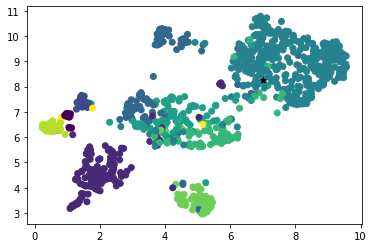

In [97]:
visualize(embedding, label=y[I[0]], )

In [98]:
imgs = dataset_labeled[I[0][:10]][1]['x']

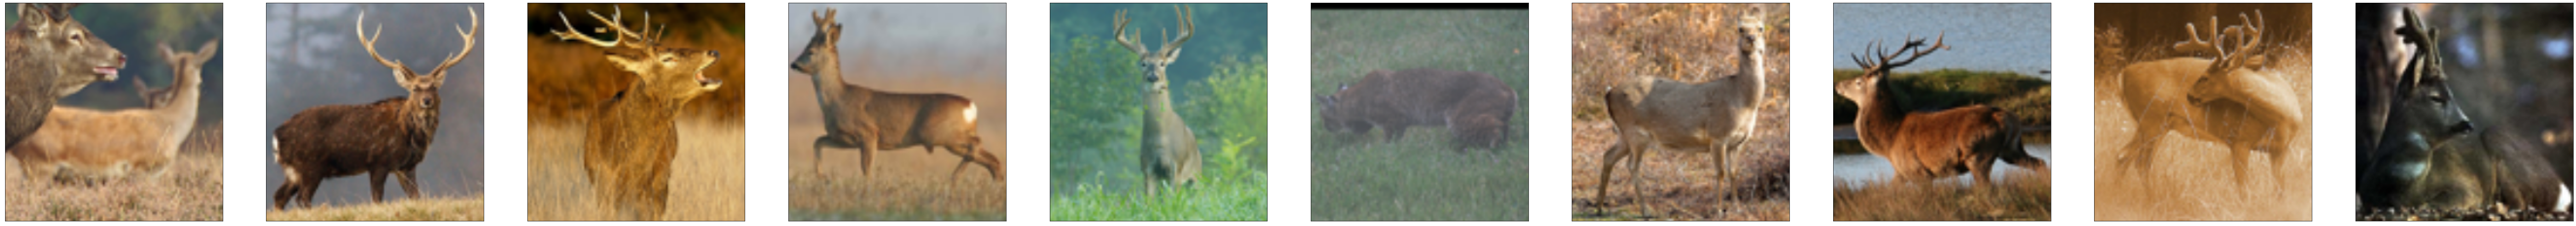

In [99]:
show(imgs)

## BigGAN

In [100]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample, save_as_images, display_in_terminal)

In [101]:
class ImageGenerator(object):
    
    def __init__(self, model='biggan-deep-256'):
        # Load pre-trained model tokenizer (vocabulary)
        self.model = BigGAN.from_pretrained('biggan-deep-256')
        
    def interpolate_classes(self, c1, c2, n=10, truncation=.4):
        
        p1 = one_hot_from_names([c1], batch_size=1)
        p2 = one_hot_from_names([c2], batch_size=1)
        morph = np.linspace(0, 1, n)[:, None]

        class_vector = (p1 * morph + p2 * (1 - morph)).astype(np.float32)

        p1 = truncated_noise_sample(truncation=truncation, batch_size=1)
        p2 = truncated_noise_sample(truncation=truncation, batch_size=1)
        noise_vector = (p1 * morph + p2 * (1 - morph)).astype(np.float32)

        noise_vector = torch.from_numpy(noise_vector)
        class_vector = torch.from_numpy(class_vector)

        # Generate an image
        with torch.no_grad():
            output = self.model(noise_vector, class_vector, truncation)
            output = torch.clip(((output + 1) / 2.0), 0, 1)
            
        return output
    
    def sample_class(self, c, n=10, truncation=.4):

        class_vector = torch.from_numpy(one_hot_from_names([c], batch_size=n))
        noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=n))

        # Generate an image
        with torch.no_grad():
            output = self.model(noise_vector, class_vector, truncation)
            output = torch.clip(((output + 1) / 2.0), 0, 1)
            
        return output
    
    def sample(self, n=10, truncation=.4):

        noise_vector = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=n))
        class_vector = F.one_hot(torch.randint(1000, size=(n,)), num_classes=1000).float()

        # Generate an image
        with torch.no_grad():
            output = self.model(noise_vector, class_vector, truncation)
            output = torch.clip(((output + 1) / 2.0), 0, 1)
            
        return output

In [102]:
generator = ImageGenerator()

In [123]:
imgs = generator.interpolate_classes('bubble', 'ship', truncation=1., n=20)
# imgs = generator.sample_class('lion', truncation=1.)
# imgs = generator.sample(truncation=1.)

## Time Shift

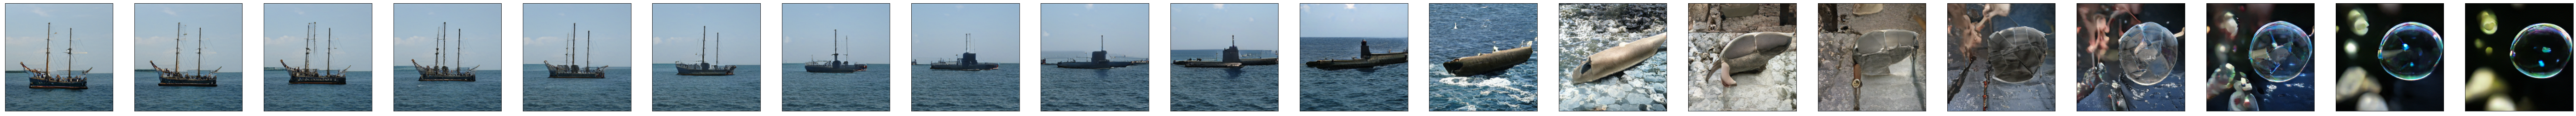

In [124]:
show(imgs)

In [125]:
z_imgs = alg.predict(imgs)

In [126]:
h_shift = z_imgs['h'][1].detach().cpu().numpy()

In [127]:
D, I = sim.most_similar(h_shift, n=1000)

In [128]:
I = np.unique(I.flatten())

In [129]:
z_shift = np.concatenate([h_shift, z[I]])

In [130]:
embedding = sim.reduce(z_shift)

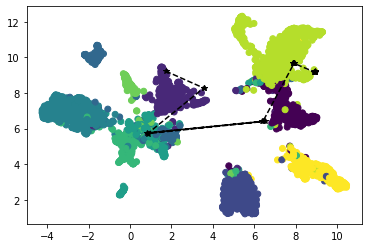

In [131]:
visualize(embedding, label=y[I], mark_first=20)

In [ ]:
imgs = interpolate_classes

In [14]:
alg.predict(imgs)

{'h': tensor([[0.3486, 0.0067, 0.0953,  ..., 0.0833, 0.1250, 0.0000],
        [0.0023, 0.0000, 0.0000,  ..., 0.2375, 0.0579, 0.0018],
        [0.0505, 0.0000, 0.0000,  ..., 0.0174, 0.1045, 0.0000],
        ...,
        [0.2641, 0.1039, 0.0233,  ..., 0.0000, 0.0096, 0.0066],
        [0.1607, 0.0033, 0.0000,  ..., 0.1728, 0.1146, 0.0000],
        [0.0521, 0.0000, 0.0000,  ..., 0.0021, 0.0165, 0.0000]]), 'z': tensor([[-0.0170, -0.0142,  0.0018,  ..., -0.0190, -0.0184, -0.0055],
        [-0.0170, -0.0248, -0.0031,  ..., -0.0189, -0.0176, -0.0116],
        [-0.0216, -0.0182, -0.0004,  ..., -0.0354, -0.0094, -0.0129],
        ...,
        [-0.0072, -0.0093, -0.0023,  ..., -0.0214, -0.0175, -0.0028],
        [-0.0316, -0.0244,  0.0033,  ..., -0.0364, -0.0142,  0.0021],
        [-0.0345, -0.0103, -0.0069,  ..., -0.0384, -0.0215, -0.0231]])}

## Mini Imagenet

In [9]:
data = pd.read_pickle('/home/shared/data/dataset/mini_imagenent/mini-imagenet-cache-test.pkl')

In [12]:
data['image_data'].shape

(12000, 84, 84, 3)

In [13]:
def show(imgs, fs=100):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(fs, fs))
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

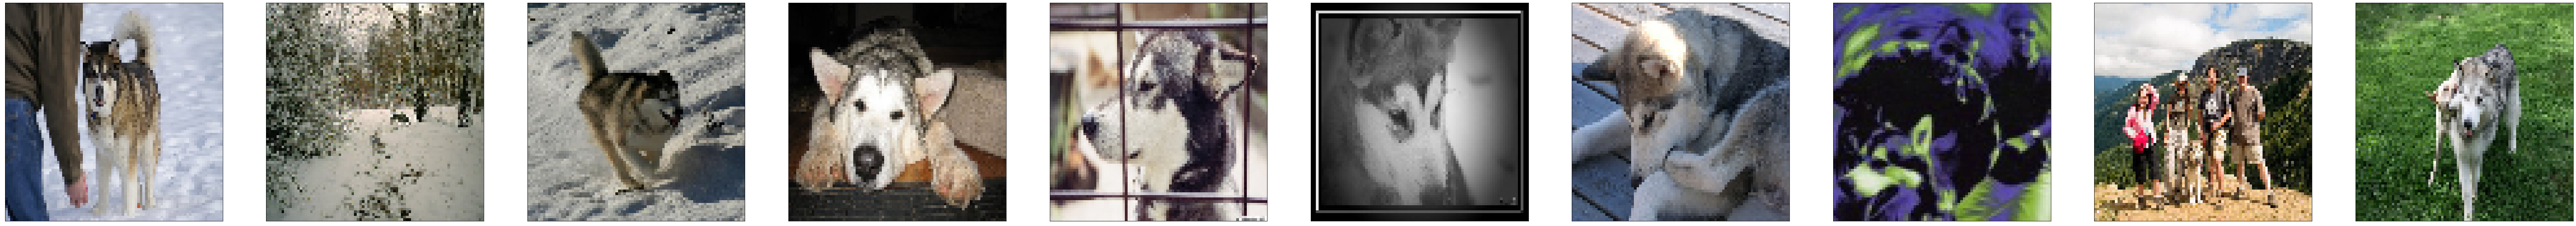

In [17]:
show(list(data['image_data'][2000:2010]))